In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import xgboost as xgb
from category_encoders import MEstimateEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from xgboost import XGBRegressor
pd.set_option('mode.chained_assignment', None)

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/datacamp/careerhub-data/master/BMW%20Used%20Car%20Sales/bmw.csv')

In [3]:
data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB


In [5]:
data['price'].describe()

count     10781.000000
mean      22733.408867
std       11415.528189
min        1200.000000
25%       14950.000000
50%       20462.000000
75%       27940.000000
max      123456.000000
Name: price, dtype: float64

In [6]:
data.shape

(10781, 9)

In [7]:
data.dtypes

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object

In [8]:
data.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [9]:
def make_countplot(data, column):
    '''Produces monocolor countplot for model, year, transmission, fuelType, and engineSize'''
    
    f, ax = plt.subplots(figsize=(8, 5))
    by_column = pd.DataFrame(data[column].value_counts()).reset_index()
    by_column.columns=[column, 'Count']
    sorted_by_column = by_column.sort_values(by=column)
    sns.barplot(x=sorted_by_column[column], y=sorted_by_column['Count'], color='blue')
    ax.set_title(f'Count by {column} of type of BMW Used Cars')
    sns.despine()
    f.autofmt_xdate()
    plt.show()

def make_histogram(data, column):
    '''Produces monocolor histogram for price, mileage, and tax'''
    
    f, ax = plt.subplots(figsize=(8, 5))
    sns.histplot(data[column], color='blue')
    ax.set_title(f'Distribution of {column} of BMW Used Cars')
    sns.despine()
    f.autofmt_xdate()
    plt.show()

def make_target_plot(data, feature, target):
    '''Makes a plot connecting the feature to the target'''
    
    f, ax = plt.subplots(figsize=(8, 5))
    if len(set(data[feature])) >= 30:
        sns.scatterplot(x=feature, y=target, data=data, color='blue')
    elif len(set(data[feature])) >= 5:
        sns.boxplot(x=feature, y=target, data=data, color='blue')
    else:
        sns.violinplot(x=feature, y=target, data=data, color='blue')
    ax.set_title(f'{target} by {feature} of BMW Used Cars')
    sns.despine()
    f.autofmt_xdate()
    plt.show()

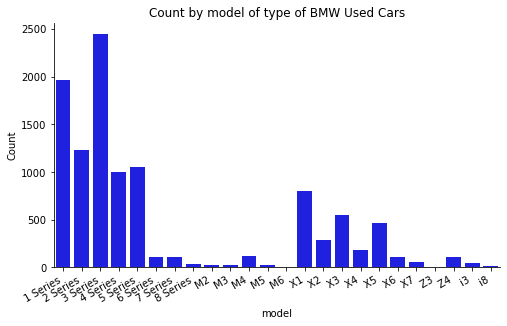

In [10]:
make_countplot(data, 'model')

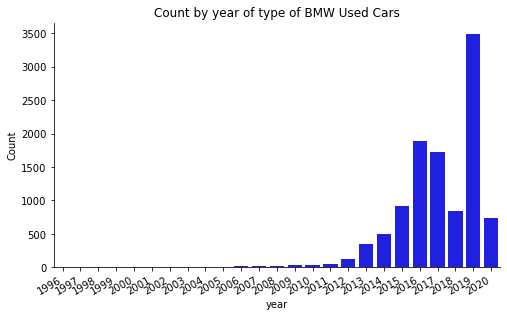

In [11]:
make_countplot(data, 'year')

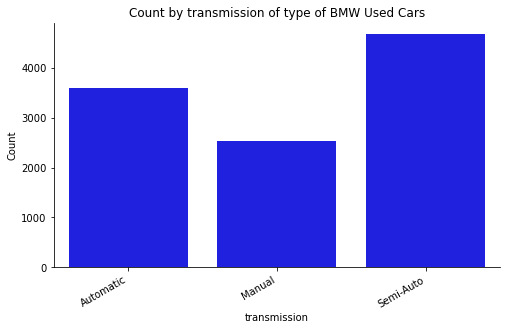

In [12]:
make_countplot(data, 'transmission')

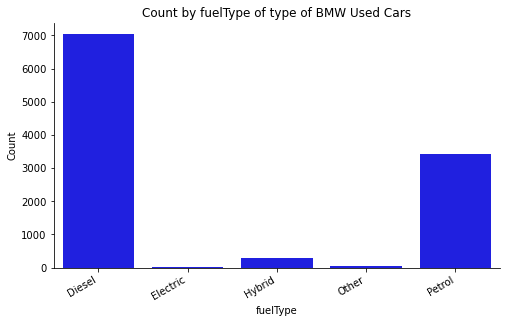

In [13]:
make_countplot(data, 'fuelType')

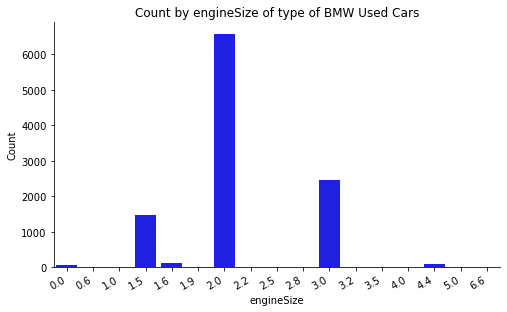

In [14]:
make_countplot(data, 'engineSize')

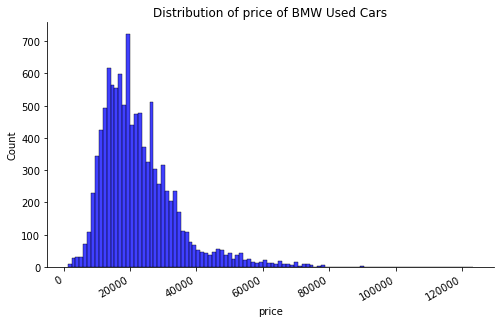

In [15]:
make_histogram(data, 'price')

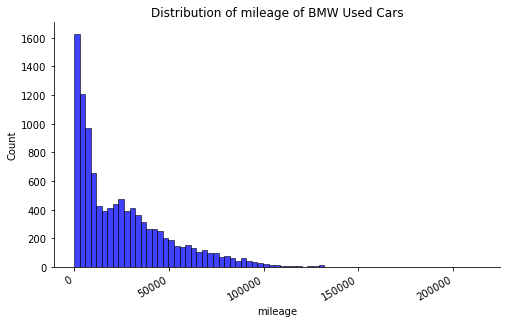

In [16]:
make_histogram(data, 'mileage')

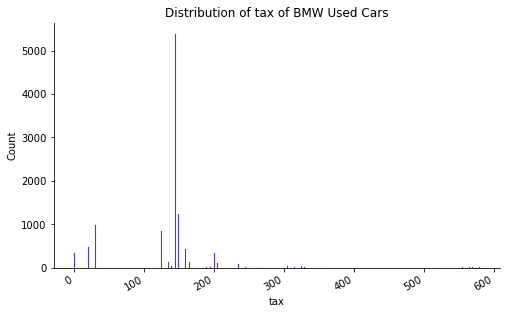

In [17]:
make_histogram(data, 'tax')

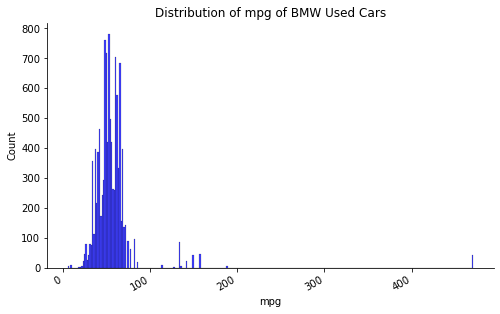

In [18]:
make_histogram(data, 'mpg')

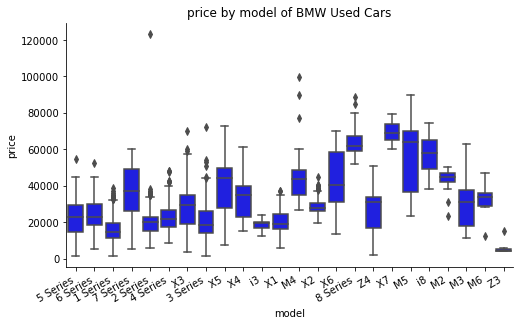

In [19]:
make_target_plot(data, 'model', 'price')

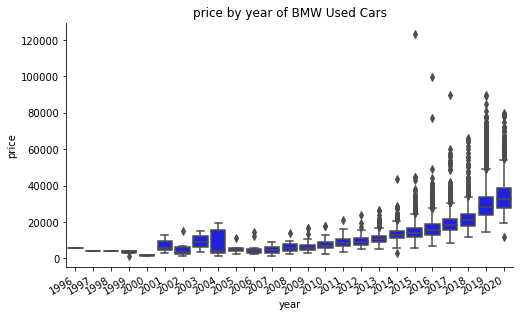

In [20]:
make_target_plot(data, 'year', 'price')

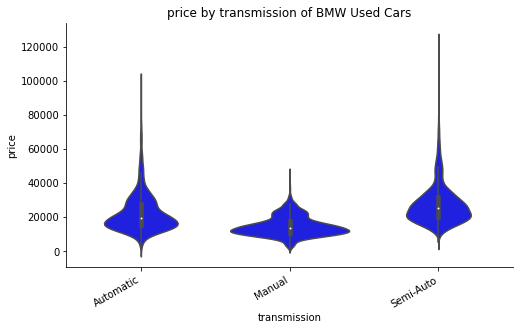

In [21]:
make_target_plot(data, 'transmission', 'price')

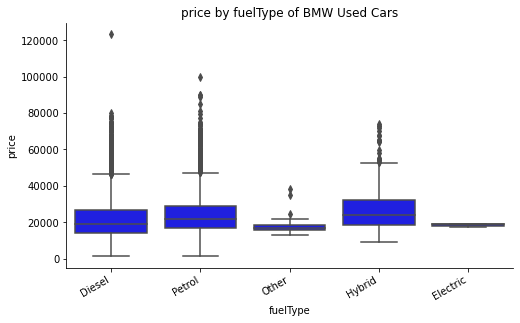

In [22]:
make_target_plot(data, 'fuelType', 'price')

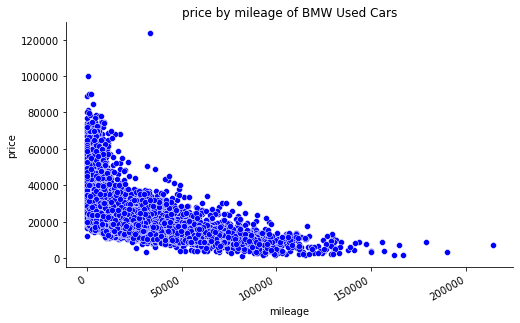

In [23]:
make_target_plot(data, 'mileage', 'price')

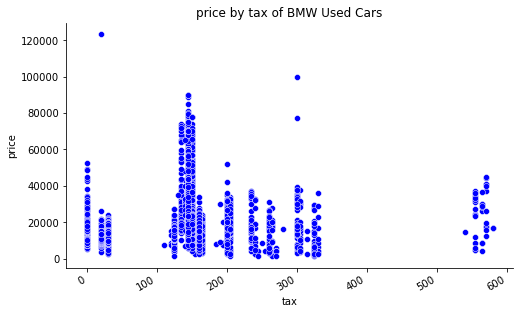

In [24]:
make_target_plot(data, 'tax', 'price')

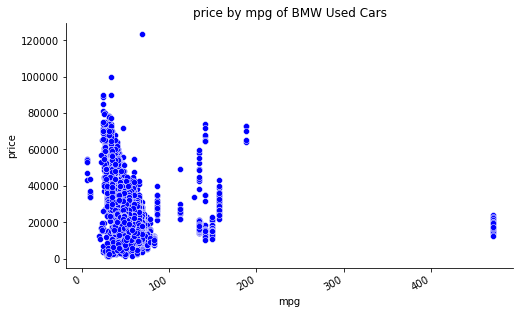

In [25]:
make_target_plot(data, 'mpg', 'price')

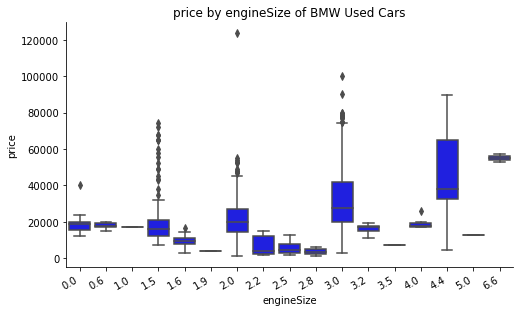

In [26]:
make_target_plot(data, 'engineSize', 'price')

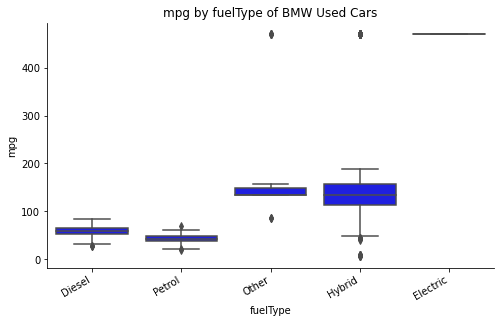

In [27]:
make_target_plot(data, 'fuelType', 'mpg')

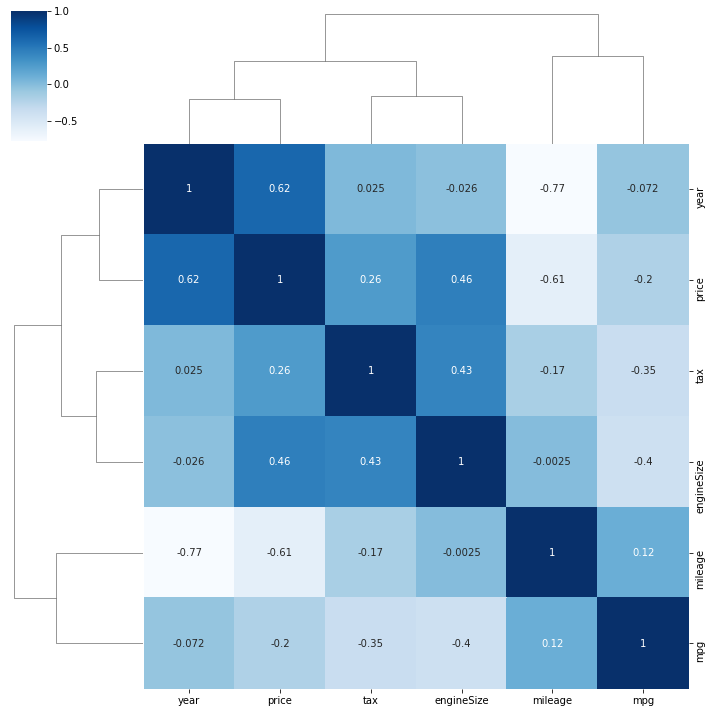

In [28]:
# Checking for correlations
sns.clustermap(data.corr(), cmap='Blues', annot=True)

In [29]:
data = data[data['price'] < 120000]
data['model'] = data['model'].astype('category')
data['transmission'] = data['transmission'].astype('category')
data['fuelType'] = data['fuelType'].astype('category')
data['year'] = data['year'].astype('int64')

In [30]:
X = data.drop(['price'], axis=1)
y = np.log1p(data['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [31]:
def evaluate_pipeline(X_train, X_test, y_train, y_test):
    """Builds and evaluates machine learning pipeline"""
    
    numerical_features = X_train.select_dtypes(include=['int64', 'float']).columns
    categorical_features = X_train.select_dtypes(include=['category']).columns
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])
    
    
    # Define numerical pipeline
    num_pipe = Pipeline([
        ('transformer', PowerTransformer()),
        ('scaler', StandardScaler())])

    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('cat', cat_pipe, categorical_features),
        ('num', num_pipe, numerical_features)])

    # Fit a pipeline with transformers and an estimator to the training data
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())])

    # Predict training data
    y_train_pred = pipe.fit(X_train, y_train)

    # Predict test data
    y_test_pred = pipe.predict(X_test)

    print(np.sqrt(mean_squared_error(np.expm1(y_test_pred), np.expm1(y_test))))

In [32]:
evaluate_pipeline(X_train, X_test, y_train, y_test)

3388.130662151753


C:\Users\tomha\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2960: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
C:\Users\tomha\Anaconda3\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\tomha\Anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [33]:
def evaluate_pipeline(X_train, X_test, y_train, y_test):
    """Builds and evaluates machine learning pipeline"""
    
    numerical_features = X_train.select_dtypes(include=['int64', 'float']).columns
    categorical_features = X_train.select_dtypes(include=['category']).columns
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    
    # Define numerical pipeline
    num_pipe = Pipeline([
        ('transformer', PowerTransformer()),
        ('scaler', StandardScaler()),
    ])

    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('cat', cat_pipe, categorical_features),
        ('num', num_pipe, numerical_features)
    ])
    
    # Fit a pipeline with transformers and an estimator to the training data
    rf_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('Random_Forest', RandomForestRegressor())
    ])
    
    # Parameters of pipelines can be set using ‘__’ separated parameter names:
    param_grid = {
        'Random_Forest__max_depth': [x for x in range(2, 20)],
        'Random_Forest__n_estimators': [100],
        'Random_Forest__n_jobs': [-1],
        'Random_Forest__random_state': [42],
        'Random_Forest__max_features': [x / 10 for x in range(2, 10)]
    }
    
    # Tune the pipeline parameters using a grid search
    search = GridSearchCV(rf_pipe, param_grid, n_jobs=-1)
    search.fit(X_train, y_train)

    # Predict training data
    y_train_pred = search.predict(X_train)

    # Predict test data
    y_test_pred = search.predict(X_test)
    
    # Print the Root Mean Squared Error on the training dataset
    print(np.sqrt(mean_squared_error(np.expm1(y_train_pred), np.expm1(y_train))))

    # Print the Root Mean Squared Error on the testing dataset
    print(np.sqrt(mean_squared_error(np.expm1(y_test_pred), np.expm1(y_test))))
    print(search.best_params_)
    
    list_categorical_features = pd.Series(search.best_estimator_.named_steps['preprocessor'].transformers_[0][1]['encoder']
                                          .get_feature_names(categorical_features))
    list_numerical_features = pd.Series(list(numerical_features))
    list_features = list_categorical_features.append(list_numerical_features)
    feature_importances = pd.DataFrame(search.best_estimator_.named_steps['Random_Forest'].feature_importances_, 
                                       list_features, columns=['Feature_Importances']).sort_values(by='Feature_Importances', 
                                       ascending=False)
    
    features = pd.DataFrame(feature_importances.index)
    features = features.apply(lambda x: x.str.split('_').map(lambda x: x[0]))
    subset_features = feature_importances.reset_index().join(features)
    subset_features.columns = ['Sub_Feature', 'Feature_Importance', 'Feature']
    final_feature_importances = subset_features.groupby('Feature').sum()
    
    return final_feature_importances

In [34]:
feature_importances = evaluate_pipeline(X_train, X_test, y_train, y_test)

C:\Users\tomha\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2960: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
C:\Users\tomha\Anaconda3\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\tomha\Anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


1161.7260777369258
2424.335030049581
{'Random_Forest__max_depth': 19, 'Random_Forest__max_features': 0.6, 'Random_Forest__n_estimators': 100, 'Random_Forest__n_jobs': -1, 'Random_Forest__random_state': 42}


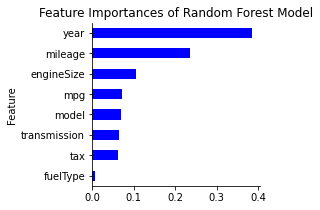

In [35]:
feature_importances['Feature_Importance'].sort_values(ascending=True).plot(kind='barh', figsize=(3, 3), color='blue',
                                                     title='Feature Importances of Random Forest Model')
sns.despine()
plt.show()

In [36]:
def evaluate_pipeline(X_train, X_test, y_train, y_test):
    """Builds and evaluates machine learning pipeline"""
    
    numerical_features = X_train.select_dtypes(include=['int64', 'float']).columns
    categorical_features = X_train.select_dtypes(include=['category']).columns
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    
    # Define numerical pipeline
    num_pipe = Pipeline([
        ('transformer', PowerTransformer()),
        ('scaler', StandardScaler())
    ])

    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('cat', cat_pipe, categorical_features),
        ('num', num_pipe, numerical_features)
    ])
    
    # Fit a pipeline with transformers and an estimator to the training data
    xg_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('XGBoost', xgb.XGBRegressor())
    ])
    
    # Parameters of pipelines can be set using ‘__’ separated parameter names:
    param_grid = {
        'XGBoost__max_depth': [x for x in range(2, 20)],
        'XGBoost__n_estimators': [100],
        'XGBoost__n_jobs': [-1],
        'XGBoost__random_state': [42],
        'XGBoost__colsample_bytree': [x / 100 for x in range(20, 100)],
        'XGBoost__lambda': [0, .001, .003, .01, .03, .1, .3, 1, 3, 10, 30, 100], 
        #anything larger than 100 gets overflow error
        'XGBoost__alpha': [0, .001, .003, .01, .03, .1, .3, 1, 3, 10, 30, 100],  
        #anything larger than 100 gets overflow error
        'XGBoost__eta': [x / 100 for x in range(1, 100)]
    }
    
    # Tune the pipeline parameters using a random search
    search = RandomizedSearchCV(xg_pipe, param_grid, n_jobs=-1, n_iter=50, random_state=42)
    search.fit(X_train, y_train)

    # Predict training data
    y_train_pred = search.predict(X_train)
    
    # Print the Root Mean Squared Error on the training dataset
    print(np.sqrt(mean_squared_error(np.expm1(y_train_pred), np.expm1(y_train))))
    
    # Predict test data
    y_test_pred = search.predict(X_test)

    # Print the Root Mean Squared Error on the testing dataset
    print(np.sqrt(mean_squared_error(np.expm1(y_test_pred), np.expm1(y_test))))
    print(search.best_params_)
    
    list_categorical_features = pd.Series(search.best_estimator_.named_steps['preprocessor'].transformers_[0][1]['encoder']
                                          .get_feature_names(categorical_features))
    list_numerical_features = pd.Series(list(numerical_features))
    list_features = list_categorical_features.append(list_numerical_features)
    feature_importances = pd.DataFrame(search.best_estimator_.named_steps['XGBoost'].feature_importances_, 
                                       list_features, columns=['Feature_Importances'])
                                       .sort_values(by='Feature_Importances', ascending=False)
    
    features = pd.DataFrame(feature_importances.index)
    features = features.apply(lambda x: x.str.split('_').map(lambda x: x[0]))
    subset_features = feature_importances.reset_index().join(features)
    subset_features.columns = ['Sub_Feature', 'Feature_Importance', 'Feature']
    final_feature_importances = subset_features.groupby('Feature').sum()
    
    return final_feature_importances

In [37]:
feature_importances = evaluate_pipeline(X_train, X_test, y_train, y_test)

C:\Users\tomha\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2960: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
C:\Users\tomha\Anaconda3\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\tomha\Anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


1541.4168943445195
2281.235190094475
{'XGBoost__random_state': 42, 'XGBoost__n_jobs': -1, 'XGBoost__n_estimators': 100, 'XGBoost__max_depth': 10, 'XGBoost__lambda': 3, 'XGBoost__eta': 0.17, 'XGBoost__colsample_bytree': 0.55, 'XGBoost__alpha': 0.1}


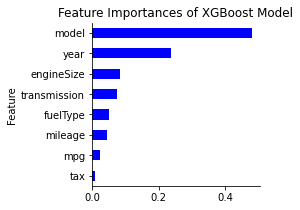

In [38]:
feature_importances['Feature_Importance'].sort_values(ascending=True).plot(kind='barh', figsize=(3,3), color='blue',
                                                     title='Feature Importances of XGBoost Model')
sns.despine()
plt.show()

In [39]:
# Create Stacking Regressor, use both Random Forest and XGBoost parameters, to predict final value of BMW price

In [40]:
actual_bmws = pd.read_excel('test_bmws.xlsx')

In [41]:
def use_pipeline(X, y, new_data):
    """Uses model to make new prediction"""
    
    numerical_features = X_train.select_dtypes(include=['int64', 'float']).columns
    categorical_features = X_train.select_dtypes(include=['category']).columns
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    
    # Define numerical pipeline
    num_pipe = Pipeline([
        ('transformer', PowerTransformer()),
        ('scaler', StandardScaler()),
    ])

    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('cat', cat_pipe, categorical_features),
        ('num', num_pipe, numerical_features)
    ])
    
    # Fit a pipeline with transformers and an estimator to the training data
    rf_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('Random_Forest', RandomForestRegressor(max_depth=19, 
                                                max_features=.6, 
                                                n_estimators=100, 
                                                n_jobs=-1, 
                                                random_state=42))
    ])
    
     # Fit a pipeline with transformers and an estimator to the training data
    xg_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('XGBoost', xgb.XGBRegressor(random_state=42, 
                                     n_jobs=-1, 
                                     n_estimators=100, 
                                     max_depth=10, 
                                     reg_lambda=3, 
                                     eta=0.17, 
                                     colsample_bytree=.55, 
                                     alpha=0.1))
    ])
    
    rf_pipe.fit(X, y)
    xg_pipe.fit(X, y)
    print(np.expm1(rf_pipe.predict(new_data)))
    print(np.expm1(xg_pipe.predict(new_data)))
    
    
    
    

In [42]:
use_pipeline(X, y, actual_bmws)

C:\Users\tomha\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2960: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
C:\Users\tomha\Anaconda3\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\tomha\Anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\tomha\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2960: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
C:\Users\tomha\Anaconda3\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\tomha\Anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


[8849.94399981 5956.80870388]
[9761.792 4260.214]
